## Figure 5

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    abs_diff = abs(b) - abs(a)
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'mean_abs_diff': np.nanmean( abs_diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

Set font sizes for plots

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Define the study area

In [4]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find all files and open

In [5]:
# original ABI images
original_filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')
ds_original = xr.open_mfdataset(original_filepaths, concat_dim='time', combine='nested')
ds_original = ds_original.rio.clip(geometry)

In [6]:
# orthorectified ABI images
ortho_filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
ds_ortho = xr.open_mfdataset(ortho_filepaths, concat_dim='time', combine='nested')
ds_ortho = ds_ortho.rio.clip(geometry)

Plot NaNs from each set (these are the same because we have the same ASTER images)

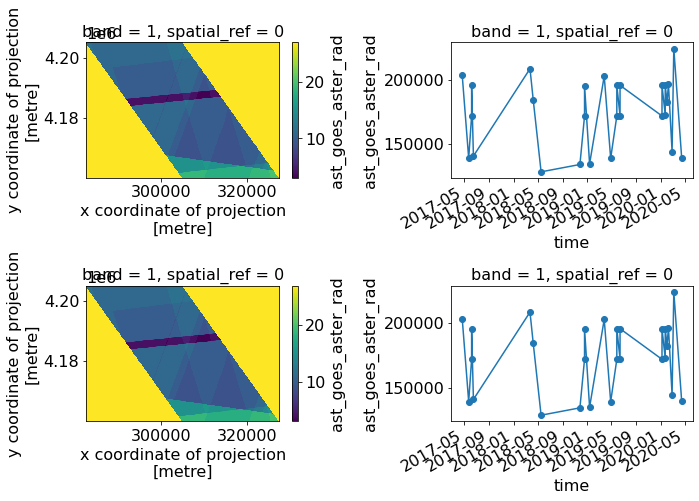

In [7]:
fig, ax = plt.subplots(2,2,figsize=(10,7),tight_layout=True)

# original
ds_original.ast_goes_aster_rad.isnull().sum(axis=(0)).plot(ax=ax[0,0])
ds_original.ast_goes_aster_rad.isnull().sum(axis=(1,2)).plot(marker='o',ax=ax[0,1])

# ortho
ds_ortho.ast_goes_aster_rad.isnull().sum(axis=(0)).plot(ax=ax[1,0])
ds_original.ast_goes_aster_rad.isnull().sum(axis=(1,2)).plot(marker='o',ax=ax[1,1])

### Make Figure 5

Modis, Original, Orthorectified histograms and 1-1 plots:

ast_mod_summary_stats: {'n': 125000, 'mean_diff': -0.19837785170585104, 'mean_abs_diff': -0.19837785170585104, 'median_diff': -0.0989601432092968, 'mean_squared_diff': 2.9115216471794034, 'rms_diff': 1.7063181553213935, 'std_diff': 1.6947471419453626, 'slope': 0.6544257540258616, 'intercept': 93.23468252450837, 'r_value': 0.7974580910506209, 'p_value': 0.0, 'std_err': 0.0014005151696966642}
ast_goes_summary_stats {'n': 125000, 'mean_diff': 1.5834247003829884, 'mean_abs_diff': 1.5834247003829884, 'median_diff': 1.4490069334402165, 'mean_squared_diff': 7.308597099236741, 'rms_diff': 2.7034417136747635, 'std_diff': 2.191201341149139, 'slope': 0.6779390592433121, 'intercept': 88.67424652389468, 'r_value': 0.6593153327199895, 'p_value': 0.0, 'std_err': 0.0021866874173385223}
ast_goes_summary_stats {'n': 125000, 'mean_diff': 1.0098791943506429, 'mean_abs_diff': 1.0098791943506429, 'median_diff': 1.1074128672594838, 'mean_squared_diff': 1.4896158653982234, 'rms_diff': 1.2204982037668977, 'std

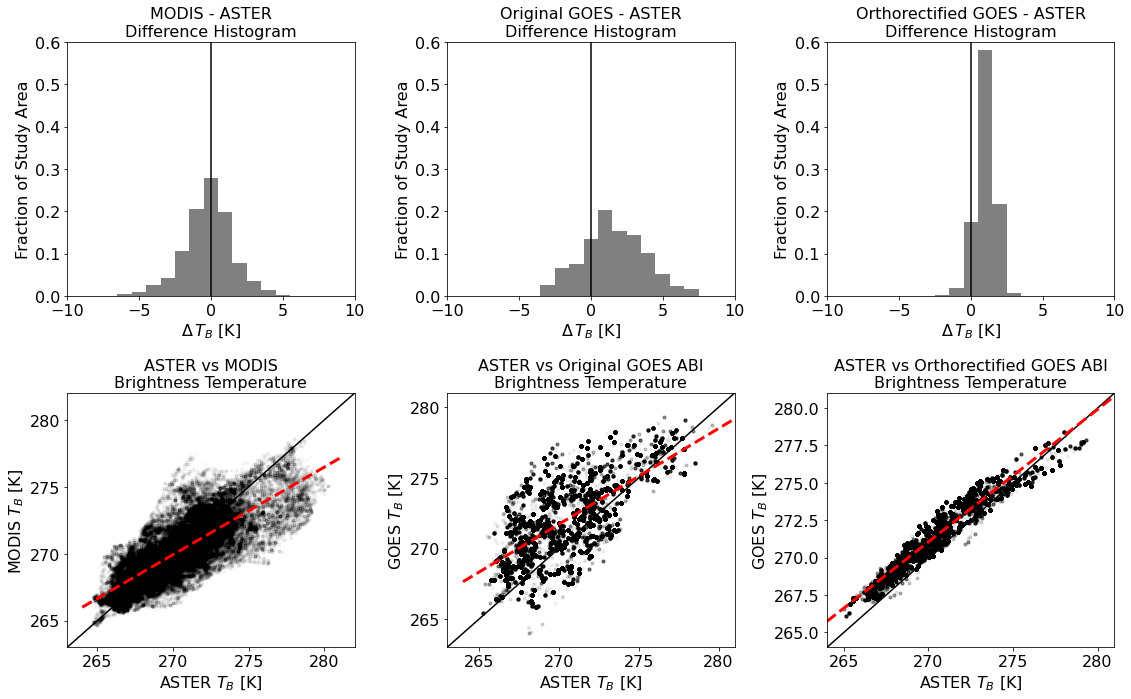

In [15]:
# datasets
_ds_original = ds_original.drop(time=ds_original.isel(time=25).time.values).mean(axis=0, skipna=True)
_ds_ortho = ds_ortho.drop(time=ds_original.isel(time=25).time.values).mean(axis=0, skipna=True)

# make figure
fig = plt.figure(figsize=(16,10), tight_layout=True)
nrows = 2
ncols = 3

# make hist plot axes
ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_ast_goes_orig_hist = plt.subplot2grid((nrows, ncols), (0, 1), 1, 1)
ax_ast_goes_ortho_hist = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)

# make 1-to-1 plots axes
ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_goes_orig_1to1 = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
ax_ast_goes_ortho_1to1 = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)


lw=3 #line widths

### Plot the difference histograms ### 
mybins = np.arange(-10.5,11.5,1)

# MODIS-ASTER
_ds_original.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.std().values,1)))
#ax_ast_mod_hist.axvline(_ds_original.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.mean().values,1))) # mean line
ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')

# Original GOES-ASTER
_ds_original.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_orig_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_original.ast_goes_mean_diff_tb.std().values,1)))
#ax_ast_goes_orig_hist.axvline(_ds_original.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_orig_hist.set_title('Original GOES - ASTER\nDifference Histogram')

# Orthorectified GOES-ASTER
_ds_ortho.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_ortho_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_ortho.ast_goes_mean_diff_tb.std().values,1)))
#ax_ast_goes_ortho_hist.axvline(_ds_ortho.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_ortho.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_ortho_hist.set_title('Orthorectified GOES - ASTER\nDifference Histogram')

### Format the axes limits on the histograms ###
for ax in [ax_ast_mod_hist, ax_ast_goes_orig_hist, ax_ast_goes_ortho_hist]:
    ax.set_xlim(-10,10)
    ax.set_ylim(0,0.6)
    ax.axvline(0, color='k', linestyle='-') # zero line
    #ax.legend(loc='upper left',facecolor='none',edgecolor='none')
    ax.set_xlabel('$\Delta\,T_B$ [K]')
    ax.set_ylabel('Fraction of Study Area')

### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ###

# ASTER and MODIS
ax_ast_mod_1to1.plot(_ds_original.ast_mod_mean_rad2tbK, _ds_original.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                      linestyle='none', marker='.', color='k', alpha=0.02)
ax_ast_mod_1to1.set_title('ASTER vs MODIS\nBrightness Temperature')
ax_ast_mod_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')

# ASTER and Original GOES
ax_ast_goes_orig_1to1.plot(_ds_original.ast_goes_mean_rad2tbK, _ds_original.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
ax_ast_goes_orig_1to1.set_title('ASTER vs Original GOES ABI\nBrightness Temperature')
ax_ast_goes_orig_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_orig_1to1.set_ylabel('GOES $T_B$ [K]')

# ASTER and Orthorectified GOES
ax_ast_goes_ortho_1to1.plot(_ds_ortho.ast_goes_mean_rad2tbK, _ds_ortho.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
ax_ast_goes_ortho_1to1.set_title('ASTER vs Orthorectified GOES ABI\nBrightness Temperature')
ax_ast_goes_ortho_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_ortho_1to1.set_ylabel('GOES $T_B$ [K]')


### 1-to-1 plots and axes formatting ###
for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_orig_1to1, ax_ast_goes_ortho_1to1]:
    # get max and min values for axes
    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
    # add 1-to-1 line
    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
    # set axes limits
    ax_1_to_1.set_xlim((ax_min,ax_max))
    ax_1_to_1.set_ylim((ax_min,ax_max))

    
    
### add linear regressions to 1-to-1 plots: ###

# MODIS - ASTER
ast_mod_summary_stats = summary_stats(_ds_original.ast_mod_mean_rad2tbK.values.ravel(), _ds_original.ast_mod_modis_tb.values.ravel())
print('ast_mod_summary_stats:',ast_mod_summary_stats)
ax_ast_mod_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_mod_summary_stats['slope'] + ast_mod_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

# Original GOES - ASTER
ast_goes_orig_summary_stats = summary_stats(_ds_original.ast_goes_mean_rad2tbK.values.ravel(), _ds_original.ast_goes_goes_tb.values.ravel())
print('ast_goes_summary_stats',ast_goes_orig_summary_stats)
ax_ast_goes_orig_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_goes_orig_summary_stats['slope'] + ast_goes_orig_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

# Orthorectified GOES - ASTER
ast_goes_ortho_summary_stats = summary_stats(_ds_ortho.ast_goes_mean_rad2tbK.values.ravel(), _ds_ortho.ast_goes_goes_tb.values.ravel())
print('ast_goes_summary_stats',ast_goes_ortho_summary_stats)
ax_ast_goes_ortho_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_goes_ortho_summary_stats['slope'] + ast_goes_ortho_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

plt.savefig('images/before-after-ortho-Figure5.png',dpi=200)

In [58]:
import scipy.stats as stats

Test the change in the mean differences before/after orthorectifying:

(null no change, alt decrease in mean)

Using a two-sided t test shows that this is a significant change in the mean. Notably though it's because we're essentially "oversampling" the GOES pixels... if we scale them (by dividing by 10000) we can make it no longer statistically significant.

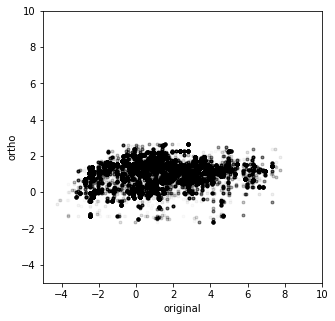

In [28]:
plt.figure(figsize=(5,5))
plt.plot(_ds_original.ast_goes_mean_diff_tb, _ds_ortho.ast_goes_mean_diff_tb,
         linestyle='none', marker='.', color='k', alpha=0.02);
plt.xlabel('original')
plt.ylabel('ortho')
plt.xlim((-5,10))
plt.ylim((-5,10));

In [68]:
# before
before = _ds_original.ast_goes_mean_diff_tb.values.ravel()
n = len(before) #/10000
print(n)

# after
after = _ds_ortho.ast_goes_mean_diff_tb.values.ravel()
m = len(after) #/10000
print(m)

# We want our alpha to be 0.05
alpha = 0.05
# This gives us a confidence of 0.95
conf = 1 - alpha

z_alpha = stats.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

# Compute the pooled standard deviaiton
pooled_sd = np.sqrt( np.nanstd(before,ddof=1)**2 / n + np.nanstd(after,ddof=1)**2 / m )

# hypothesizing no change
mu_0 = 0

# compute z-score
zscore = (np.nanmean(after) - np.nanmean(before) - mu_0)/pooled_sd

print("z-score = {}".format( np.round(zscore,2) )) 

pvalue = 1 - stats.norm.cdf(zscore)
print("p = {}".format( np.round(pvalue,3) ))

249500
249500
z_alpha = 1.6448536269514722
z-score = -124.78
p = 1.0


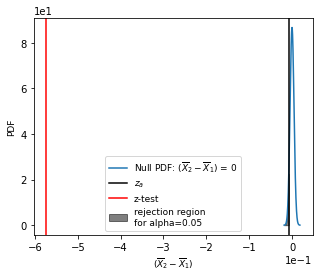

In [77]:
# Create z values between -4 and 4 to look at the middle portion of the z-distribution around 0
# Scale our values by the pooled standard deviation (otherwise we'd be in generic z-distribution space)
z = np.linspace(-4, 4, num=160) * pooled_sd

# Create the plot
plt.figure(figsize=(5,4))
# Plot the z-distribution here
plt.plot(z, stats.norm.pdf(z, 0, pooled_sd), label='Null PDF: ($\overline{X}_2 - \overline{X}_1$) = 0')

# Plot a line at our z-alpha value and shade the rejection region
plt.axvline(-z_alpha*pooled_sd, color='black', linestyle='-', label='$z_{a}$')
shade = np.linspace(-z_alpha*pooled_sd, np.min(z), 10)
plt.fill_between(shade, stats.norm.pdf(shade, 0, pooled_sd) ,  color='k', alpha=0.5, label='rejection region\nfor alpha={}'.format(np.round(1-conf,2)))


plt.axvline(zscore*pooled_sd, color='red', linestyle='-', label='z-test')
plt.xlabel('($\overline{X}_2 - \overline{X}_1$)', fontsize=9)
plt.ylabel('PDF', fontsize=9)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#plt.ylim(0, 9e-5)
plt.legend(loc='best', fontsize=9);

Test the change in the standard deviation before/after orthorectifying:

(null no change, alt decrease in standard deviation) chi-square test

In [70]:
# first calculate the test statistic
sd1 = np.nanstd(before) #we pretend this is the "true population standard deviation)
sd2 = np.nanstd(after)
m = len(after)
t = (m-1)*sd2**2/sd1**2
print(t)

24410.64108435452


In [71]:
alpha = 0.05
critical_value = stats.chi2.ppf(alpha, m-1)
print(critical_value)

248338.2169836606


------
------

### Average plots

(skipping the image set at time index = 25)

Original:

ast_mod_summary_stats: {'n': 125000, 'mean_diff': -0.19837785170585104, 'mean_abs_diff': -0.19837785170585104, 'median_diff': -0.0989601432092968, 'mean_squared_diff': 2.9115216471794034, 'rms_diff': 1.7063181553213935, 'std_diff': 1.6947471419453626, 'slope': 0.6544257540258616, 'intercept': 93.23468252450837, 'r_value': 0.7974580910506209, 'p_value': 0.0, 'std_err': 0.0014005151696966642}
ast_goes_summary_stats {'n': 125000, 'mean_diff': 1.5834247003829884, 'mean_abs_diff': 1.5834247003829884, 'median_diff': 1.4490069334402165, 'mean_squared_diff': 7.308597099236741, 'rms_diff': 2.7034417136747635, 'std_diff': 2.191201341149139, 'slope': 0.6779390592433121, 'intercept': 88.67424652389468, 'r_value': 0.6593153327199895, 'p_value': 0.0, 'std_err': 0.0021866874173385223}


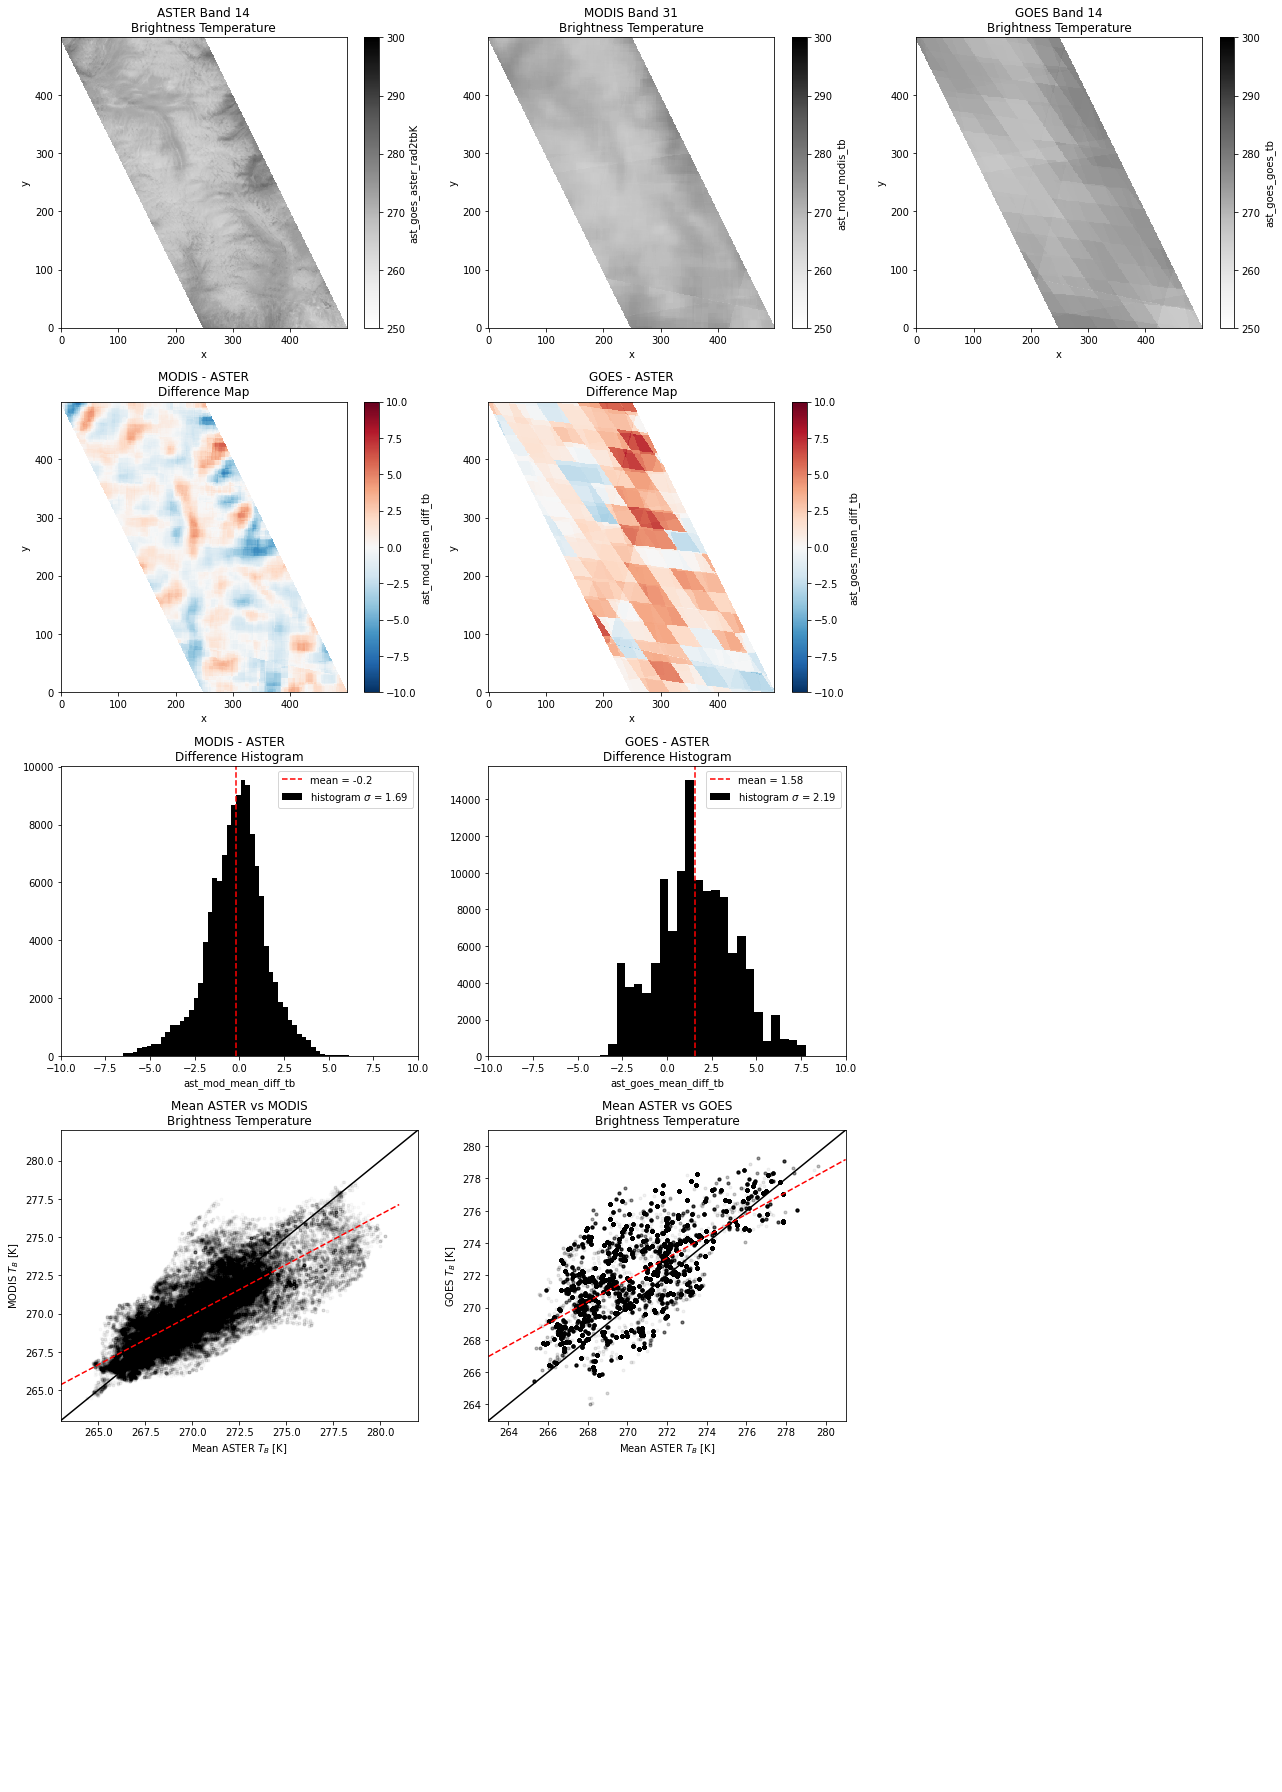

In [7]:
_ds = ds_original.drop(time=ds_original.isel(time=25).time.values).mean(axis=0, skipna=True)


fig = plt.figure(figsize=(18,25), tight_layout=True)
    
##### Format figure subplots with subplot2grid:
##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)

nrows = 5
ncols = 3

ax_aster_tb = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_modis_tb = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
ax_goes_tb = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)

ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
ax_ast_goes_1to1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
blank.set_axis_off()
    
blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
blank.set_axis_off()

####################################################################################


# make timestamp string for use in figure titles
timestamp_str = ''#str(_ds.time.values).split('.')[0]

### Plot the brightness temperature images ###
# ASTER Tb
_ds.ast_goes_aster_rad2tbK.plot(ax=ax_aster_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_aster_tb.set_title('ASTER Band 14\nBrightness Temperature')
# MODIS Tb
_ds.ast_mod_modis_tb.plot(ax=ax_modis_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_modis_tb.set_title('MODIS Band 31\nBrightness Temperature')
# GOES Tb
_ds.ast_goes_goes_tb.plot(ax=ax_goes_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_goes_tb.set_title('GOES Band 14\nBrightness Temperature')

### Plot the difference maps for MODIS-ASTER, and GOES-ASTER ###
_ds.ast_mod_mean_diff_tb.plot(ax=ax_ast_mod_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_mod_diff.set_title('MODIS - ASTER\nDifference Map')
_ds.ast_goes_mean_diff_tb.plot(ax=ax_ast_goes_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_goes_diff.set_title('GOES - ASTER\nDifference Map')

### Plot the difference histograms for MODIS-ASTER, and GOES-ASTER ###
_ds.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=50, color='k', label='histogram $\sigma$ = {}'.format(np.round(_ds.ast_mod_mean_diff_tb.std().values,2)))
ax_ast_mod_hist.axvline(_ds.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--', label='mean = {}'.format(np.round(_ds.ast_mod_mean_diff_tb.mean().values,2))) # mean line
ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')
_ds.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_hist, bins=25, color='k', label='histogram $\sigma$ = {}'.format(np.round(_ds.ast_goes_mean_diff_tb.std().values,2)))
ax_ast_goes_hist.axvline(_ds.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', label='mean = {}'.format(np.round(_ds.ast_goes_mean_diff_tb.mean().values,2))) # mean line
ax_ast_goes_hist.set_title('GOES - ASTER\nDifference Histogram')
# Format the axes limits on the histograms
for ax in [ax_ast_mod_hist, ax_ast_goes_hist]:
    ax.set_xlim(-10,10)
    ax.legend()
    #ax.set_ylim()

### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ##
# ASTER and MODIS
ax_ast_mod_1to1.plot(_ds.ast_mod_mean_rad2tbK, _ds.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                      linestyle='none', marker='.', color='k', alpha=0.02)
#ax_ast_mod_1to1.plot(_ds.ast_mod_aster_rad2tbK, _ds.ast_mod_modis_tb, # subpixel ASTER vs MODIS
#                      linestyle='none', marker='.', color='k', alpha=1)
ax_ast_mod_1to1.set_title('Mean ASTER vs MODIS\nBrightness Temperature')
ax_ast_mod_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')
# ASTER and GOES
ax_ast_goes_1to1.plot(_ds.ast_goes_mean_rad2tbK, _ds.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
#ax_ast_goes_1to1.plot(_ds.ast_goes_aster_rad2tbK, _ds.ast_goes_goes_tb, # subpixel ASTER vs GOES
#                      linestyle='none', marker='.', color='k', alpha=1)
ax_ast_goes_1to1.set_title('Mean ASTER vs GOES\nBrightness Temperature')
ax_ast_goes_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
ax_ast_goes_1to1.set_ylabel('GOES $T_B$ [K]')

### Summary Stats ###
summary_stats_ast_mod = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
summary_stats_ast_subpx_mod = summary_stats(_ds.ast_mod_aster_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
summary_stats_ast_goes = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
summary_stats_ast_subpx_goes = summary_stats(_ds.ast_goes_aster_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
## compile summary stats into a pandas dataframe
## Update key names
#_summary_stats_ast_mod = { 'ast_mod_'+k: v for k, v in summary_stats_ast_mod.items() }
#_summary_stats_ast_subpx_mod = { 'ast_subpx_mod_'+k: v for k, v in summary_stats_ast_subpx_mod.items() }
#_summary_stats_ast_goes = { 'ast_goes_'+k: v for k, v in summary_stats_ast_goes.items() }
#_summary_stats_ast_subpx_goes = { 'ast_subpx_goes_'+k: v for k, v in summary_stats_ast_subpx_goes.items() }

## merge all three dictionaries together with some other data values
#summary_stats_dict = {'time' : _ds.time.values,
#                      'aster_rad_filepath': _ds.attrs['aster_rad_filepath'],
#                      'modis_rad_filepath': _ds.attrs['modis_rad_filepath'],
#                      'goes_rad_filepath': _ds.attrs['goes_rad_filepath'],
#                      'goes_zones_filepath': _ds.attrs['goes_zones_filepath'],
#                      'goes_tb_filepath': _ds.attrs['goes_tb_filepath'],
#                      **_summary_stats_ast_mod, **_summary_stats_ast_subpx_mod,
#                      **_summary_stats_ast_goes, **_summary_stats_ast_subpx_goes}    

    
# append summary stats to list of all summary stats
#summary_stats_list.append(summary_stats_dict)



# 1-to-1 plots and axes formatting
for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
    # get max and min values for axes
    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
    # add 1-to-1 line
    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
    # set axes limits
    ax_1_to_1.set_xlim((ax_min,ax_max))
    ax_1_to_1.set_ylim((ax_min,ax_max))
    
    
# add linear regressions to 1-to-1 plots:
# MODIS - ASTER
ast_mod_summary_stats = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
print('ast_mod_summary_stats:',ast_mod_summary_stats)
ax_ast_mod_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_mod_summary_stats['slope'] + ast_mod_summary_stats['intercept'],linestyle='--', color='r')
# GOES - ASTER
ast_goes_summary_stats = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
print('ast_goes_summary_stats',ast_goes_summary_stats)
ax_ast_goes_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_goes_summary_stats['slope'] + ast_goes_summary_stats['intercept'],linestyle='--', color='r')


## Add Gaylor Pit and CUES temperatures to 1-to-1 plots, along the 1-to-1 line:
#for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#    ax_1_to_1.plot(this_cues_tss+273.15, this_cues_tss+273.15, color='tab:blue', linestyle='none', marker='P', markersize=12, label='CUES $T_{ss}$')
#    ax_1_to_1.plot(this_tuol_tss+273.15, this_tuol_tss+273.15, color='tab:blue', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_{ss}$')
#    ax_1_to_1.plot(this_cues_tair+273.15, this_cues_tair+273.15, color='tab:green', linestyle='none', marker='P', markersize=12, label='CUES $T_a$')
#    ax_1_to_1.plot(this_tuol_tair+273.15, this_tuol_tair+273.15, color='tab:green', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_a$')
#    ax_1_to_1.legend()
    
# Plot an outline of the study area, and Gaylor Pit and CUES markers on the map axes
#for ax in [ax_aster_tb, ax_modis_tb, ax_goes_tb, ax_ast_mod_diff, ax_ast_goes_diff]:
#    ax.set_xlim((utm_e_UL-1000,utm_e_LR+1000))
#    ax.set_ylim((utm_n_LR-1000,utm_n_UL+1000))
#    
#    ax.scatter(296649, 4195210, 
#                        marker='o', 
#                        edgecolor='k', 
#                        facecolor='w', 
#                        s=100, 
#                        label='Gaylor Pit')
#    ax.scatter(320971, 4168153, 
#                        marker='o', 
#                        edgecolor='k', 
#                        facecolor='w', 
#                        s=100, 
#                        label='CUES')
#    ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                     [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                     linestyle='-', color='k')
#    
    

## add title at bottom of figure    
#fig.suptitle('{}\n{}\n{}\n{}\n{}\n{}'.format(timestamp_str,
#                                     _ds.attrs['aster_rad_filepath'],
#                                     _ds.attrs['modis_rad_filepath'],
#                                     _ds.attrs['goes_rad_filepath'],
#                                     _ds.attrs['goes_zones_filepath'],
#                                     _ds.attrs['goes_tb_filepath']),
#            x=0, y=0.15, ha='left', fontsize=13);

#filename_friendly_timestamp_str = timestamp_str.replace(':','')
#if save_figure == True:
#    plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_orthorectified_{}.jpg'.format(filename_friendly_timestamp_str))
#    #plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_original_{}.jpg'.format(filename_friendly_timestamp_str))
#

Orthorectified:

ast_mod_summary_stats: {'n': 125000, 'mean_diff': -0.19837785170585104, 'mean_abs_diff': -0.19837785170585104, 'median_diff': -0.0989601432092968, 'mean_squared_diff': 2.9115216471794034, 'rms_diff': 1.7063181553213935, 'std_diff': 1.6947471419453626, 'slope': 0.6544257540258616, 'intercept': 93.23468252450837, 'r_value': 0.7974580910506209, 'p_value': 0.0, 'std_err': 0.0014005151696966642}
ast_goes_summary_stats {'n': 125000, 'mean_diff': 1.0098791943506429, 'mean_abs_diff': 1.0098791943506429, 'median_diff': 1.1074128672594838, 'mean_squared_diff': 1.4896158653982234, 'rms_diff': 1.2204982037668977, 'std_diff': 0.6853903108564635, 'slope': 0.8854079731715631, 'intercept': 31.996380286599702, 'r_value': 0.9655967651649848, 'p_value': 0.0, 'std_err': 0.0006744394236141388}


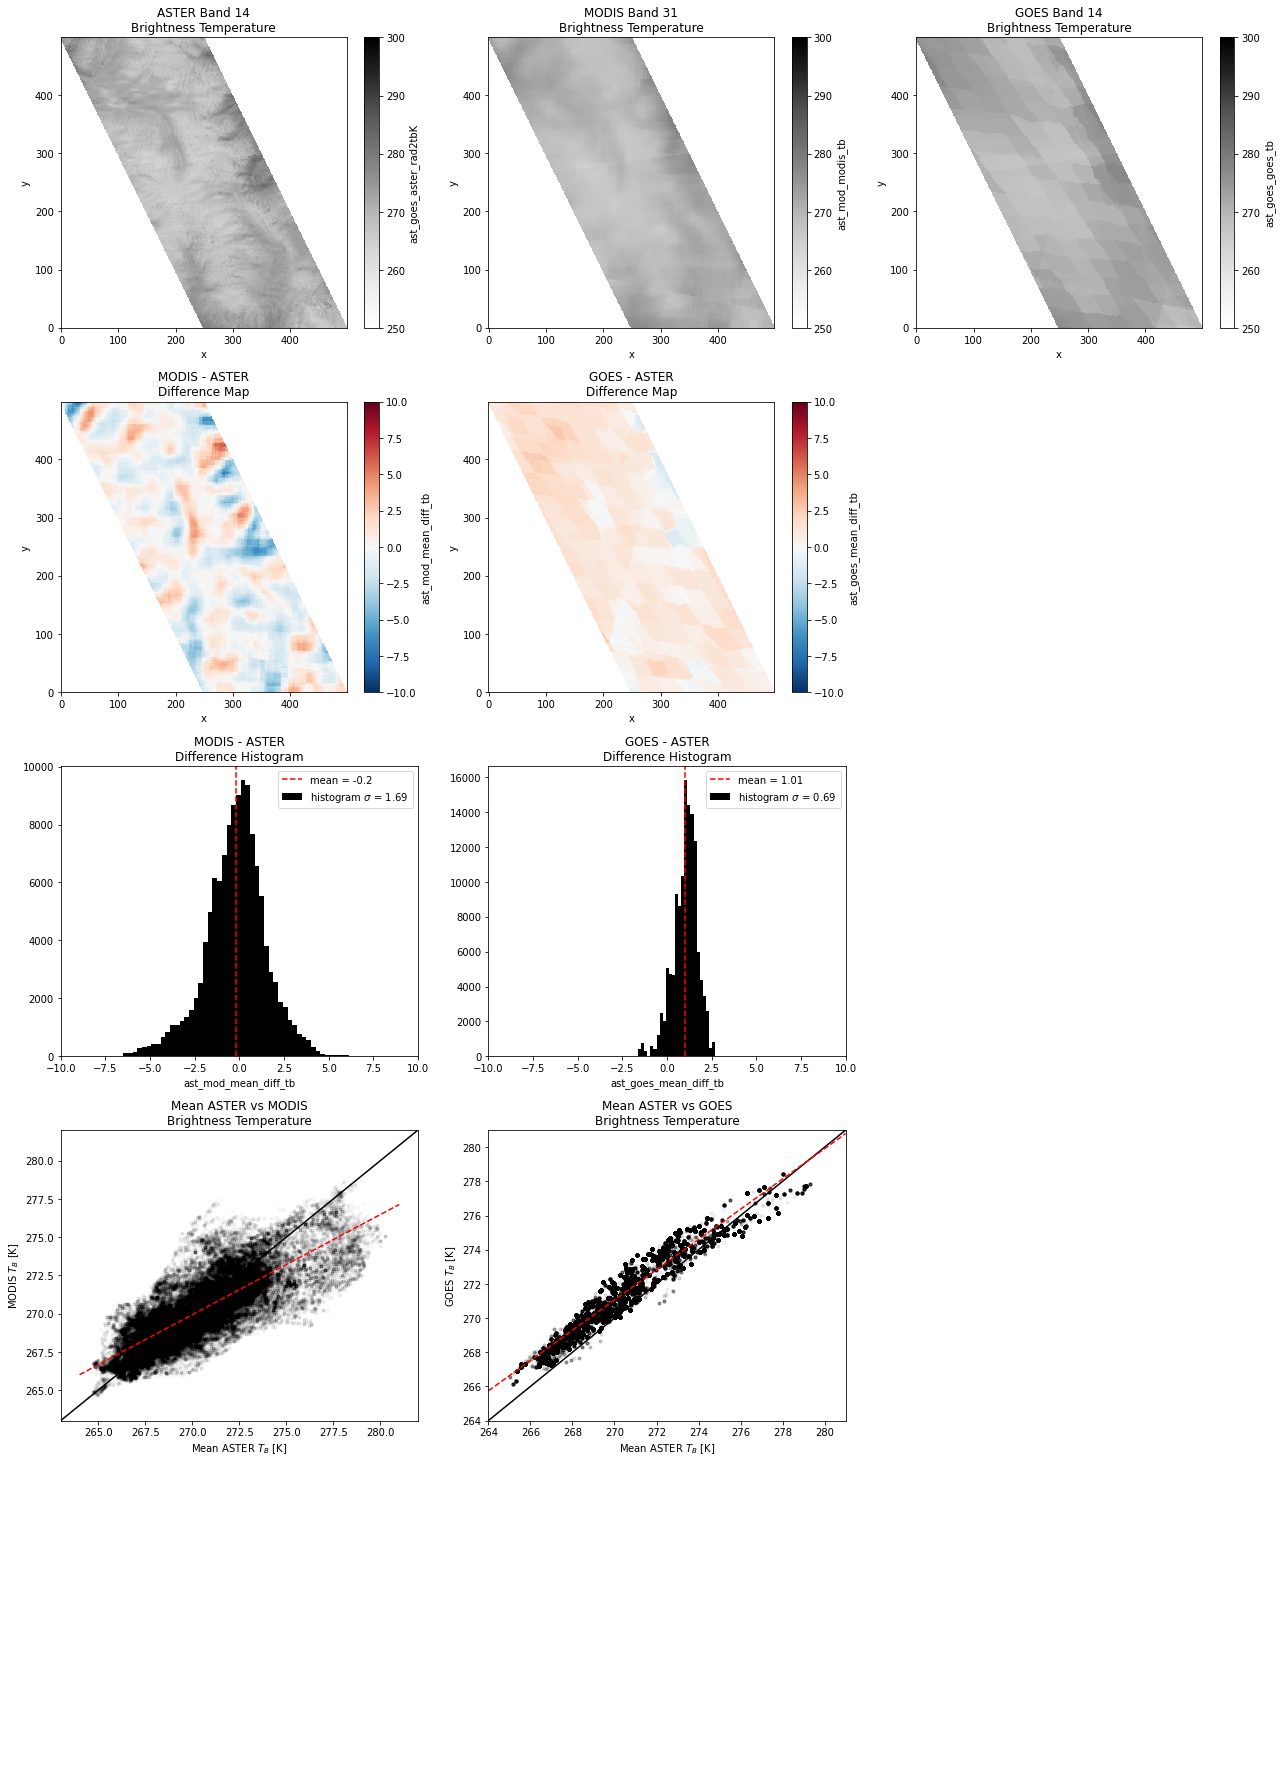

In [8]:
_ds = ds_ortho.drop(time=ds_ortho.isel(time=25).time.values).mean(axis=0, skipna=True)


fig = plt.figure(figsize=(18,25), tight_layout=True)
    
##### Format figure subplots with subplot2grid:
##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)

nrows = 5
ncols = 3

ax_aster_tb = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_modis_tb = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
ax_goes_tb = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)

ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
ax_ast_goes_1to1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
blank.set_axis_off()
    
blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
blank.set_axis_off()

####################################################################################


# make timestamp string for use in figure titles
timestamp_str = ''#str(_ds.time.values).split('.')[0]

### Plot the brightness temperature images ###
# ASTER Tb
_ds.ast_goes_aster_rad2tbK.plot(ax=ax_aster_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_aster_tb.set_title('ASTER Band 14\nBrightness Temperature')
# MODIS Tb
_ds.ast_mod_modis_tb.plot(ax=ax_modis_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_modis_tb.set_title('MODIS Band 31\nBrightness Temperature')
# GOES Tb
_ds.ast_goes_goes_tb.plot(ax=ax_goes_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
ax_goes_tb.set_title('GOES Band 14\nBrightness Temperature')

### Plot the difference maps for MODIS-ASTER, and GOES-ASTER ###
_ds.ast_mod_mean_diff_tb.plot(ax=ax_ast_mod_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_mod_diff.set_title('MODIS - ASTER\nDifference Map')
_ds.ast_goes_mean_diff_tb.plot(ax=ax_ast_goes_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_goes_diff.set_title('GOES - ASTER\nDifference Map')

### Plot the difference histograms for MODIS-ASTER, and GOES-ASTER ###
_ds.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=50, color='k', label='histogram $\sigma$ = {}'.format(np.round(_ds.ast_mod_mean_diff_tb.std().values,2)))
ax_ast_mod_hist.axvline(_ds.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--', label='mean = {}'.format(np.round(_ds.ast_mod_mean_diff_tb.mean().values,2))) # mean line
ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')
_ds.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_hist, bins=25, color='k', label='histogram $\sigma$ = {}'.format(np.round(_ds.ast_goes_mean_diff_tb.std().values,2)))
ax_ast_goes_hist.axvline(_ds.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', label='mean = {}'.format(np.round(_ds.ast_goes_mean_diff_tb.mean().values,2))) # mean line
ax_ast_goes_hist.set_title('GOES - ASTER\nDifference Histogram')
# Format the axes limits on the histograms
for ax in [ax_ast_mod_hist, ax_ast_goes_hist]:
    ax.set_xlim(-10,10)
    ax.legend()
    #ax.set_ylim()

### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ##
# ASTER and MODIS
ax_ast_mod_1to1.plot(_ds.ast_mod_mean_rad2tbK, _ds.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                      linestyle='none', marker='.', color='k', alpha=0.02)
#ax_ast_mod_1to1.plot(_ds.ast_mod_aster_rad2tbK, _ds.ast_mod_modis_tb, # subpixel ASTER vs MODIS
#                      linestyle='none', marker='.', color='k', alpha=1)
ax_ast_mod_1to1.set_title('Mean ASTER vs MODIS\nBrightness Temperature')
ax_ast_mod_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')
# ASTER and GOES
ax_ast_goes_1to1.plot(_ds.ast_goes_mean_rad2tbK, _ds.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
#ax_ast_goes_1to1.plot(_ds.ast_goes_aster_rad2tbK, _ds.ast_goes_goes_tb, # subpixel ASTER vs GOES
#                      linestyle='none', marker='.', color='k', alpha=1)
ax_ast_goes_1to1.set_title('Mean ASTER vs GOES\nBrightness Temperature')
ax_ast_goes_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
ax_ast_goes_1to1.set_ylabel('GOES $T_B$ [K]')

### Summary Stats ###
summary_stats_ast_mod = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
summary_stats_ast_subpx_mod = summary_stats(_ds.ast_mod_aster_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
summary_stats_ast_goes = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
summary_stats_ast_subpx_goes = summary_stats(_ds.ast_goes_aster_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
## compile summary stats into a pandas dataframe
## Update key names
#_summary_stats_ast_mod = { 'ast_mod_'+k: v for k, v in summary_stats_ast_mod.items() }
#_summary_stats_ast_subpx_mod = { 'ast_subpx_mod_'+k: v for k, v in summary_stats_ast_subpx_mod.items() }
#_summary_stats_ast_goes = { 'ast_goes_'+k: v for k, v in summary_stats_ast_goes.items() }
#_summary_stats_ast_subpx_goes = { 'ast_subpx_goes_'+k: v for k, v in summary_stats_ast_subpx_goes.items() }

## merge all three dictionaries together with some other data values
#summary_stats_dict = {'time' : _ds.time.values,
#                      'aster_rad_filepath': _ds.attrs['aster_rad_filepath'],
#                      'modis_rad_filepath': _ds.attrs['modis_rad_filepath'],
#                      'goes_rad_filepath': _ds.attrs['goes_rad_filepath'],
#                      'goes_zones_filepath': _ds.attrs['goes_zones_filepath'],
#                      'goes_tb_filepath': _ds.attrs['goes_tb_filepath'],
#                      **_summary_stats_ast_mod, **_summary_stats_ast_subpx_mod,
#                      **_summary_stats_ast_goes, **_summary_stats_ast_subpx_goes}    

    
# append summary stats to list of all summary stats
#summary_stats_list.append(summary_stats_dict)



# 1-to-1 plots and axes formatting
for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
    # get max and min values for axes
    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
    # add 1-to-1 line
    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
    # set axes limits
    ax_1_to_1.set_xlim((ax_min,ax_max))
    ax_1_to_1.set_ylim((ax_min,ax_max))
    
    
# add linear regressions to 1-to-1 plots:
# MODIS - ASTER
ast_mod_summary_stats = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
print('ast_mod_summary_stats:',ast_mod_summary_stats)
ax_ast_mod_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_mod_summary_stats['slope'] + ast_mod_summary_stats['intercept'],linestyle='--', color='r')
# GOES - ASTER
ast_goes_summary_stats = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
print('ast_goes_summary_stats',ast_goes_summary_stats)
ax_ast_goes_1to1.plot(np.array([ax_min, ax_max]), np.array([ax_min, ax_max])*ast_goes_summary_stats['slope'] + ast_goes_summary_stats['intercept'],linestyle='--', color='r')


## Add Gaylor Pit and CUES temperatures to 1-to-1 plots, along the 1-to-1 line:
#for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#    ax_1_to_1.plot(this_cues_tss+273.15, this_cues_tss+273.15, color='tab:blue', linestyle='none', marker='P', markersize=12, label='CUES $T_{ss}$')
#    ax_1_to_1.plot(this_tuol_tss+273.15, this_tuol_tss+273.15, color='tab:blue', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_{ss}$')
#    ax_1_to_1.plot(this_cues_tair+273.15, this_cues_tair+273.15, color='tab:green', linestyle='none', marker='P', markersize=12, label='CUES $T_a$')
#    ax_1_to_1.plot(this_tuol_tair+273.15, this_tuol_tair+273.15, color='tab:green', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_a$')
#    ax_1_to_1.legend()
    
# Plot an outline of the study area, and Gaylor Pit and CUES markers on the map axes
#for ax in [ax_aster_tb, ax_modis_tb, ax_goes_tb, ax_ast_mod_diff, ax_ast_goes_diff]:
#    ax.set_xlim((utm_e_UL-1000,utm_e_LR+1000))
#    ax.set_ylim((utm_n_LR-1000,utm_n_UL+1000))
#    
#    ax.scatter(296649, 4195210, 
#                        marker='o', 
#                        edgecolor='k', 
#                        facecolor='w', 
#                        s=100, 
#                        label='Gaylor Pit')
#    ax.scatter(320971, 4168153, 
#                        marker='o', 
#                        edgecolor='k', 
#                        facecolor='w', 
#                        s=100, 
#                        label='CUES')
#    ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                     [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                     linestyle='-', color='k')
#    
    

## add title at bottom of figure    
#fig.suptitle('{}\n{}\n{}\n{}\n{}\n{}'.format(timestamp_str,
#                                     _ds.attrs['aster_rad_filepath'],
#                                     _ds.attrs['modis_rad_filepath'],
#                                     _ds.attrs['goes_rad_filepath'],
#                                     _ds.attrs['goes_zones_filepath'],
#                                     _ds.attrs['goes_tb_filepath']),
#            x=0, y=0.15, ha='left', fontsize=13);

#filename_friendly_timestamp_str = timestamp_str.replace(':','')
#if save_figure == True:
#    plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_orthorectified_{}.jpg'.format(filename_friendly_timestamp_str))
#    #plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_original_{}.jpg'.format(filename_friendly_timestamp_str))
#